In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-07-03 01:09:41.815677: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 01:09:42.373393: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-07-03 01:09:42.984397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 01:09:43.041651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 01:09:43.041866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2023-07-03 01:09:43.069648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 01:09:43.069863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 01:09:43.069995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-07-03 01:09:43.565635: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 01:09:43.565831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 01:09:43.565958: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [6]:
len(df_data)

5785

In [7]:
# df_cov = pd.read_csv(data_folder+'covsys_000.txt', sep='\\n')
# df_cov.head()

In [8]:
# cov = df_cov.values
# len(cov)

In [9]:
# cov = cov.reshape((len(df_data), len(df_data)))
# np.shape(cov)

In [10]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


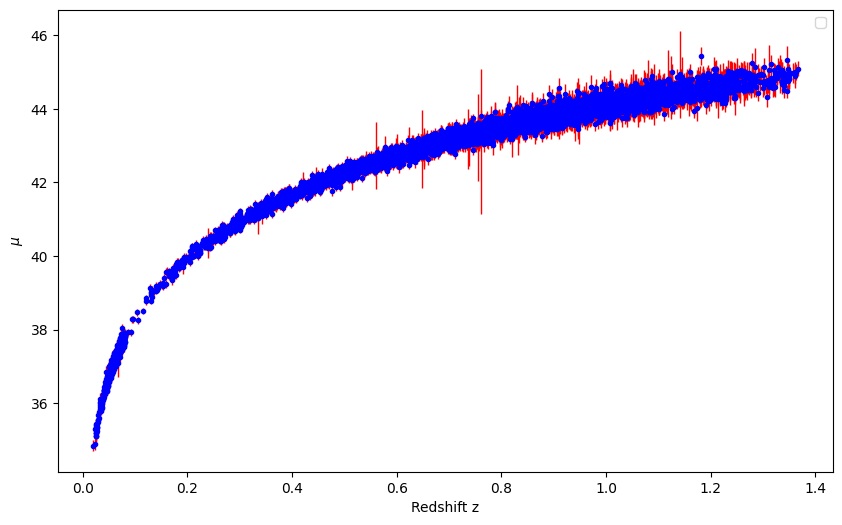

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [12]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [13]:
len(df_data)

5785

In [14]:
df_data.head()

,zCMB,MU,errors
0,0.01988,34.84680,0.13996
1,0.02321,34.89863,0.16230
2,0.02364,35.28915,0.13201
3,0.02470,35.11988,0.15157
4,0.02471,35.19347,0.13022


In [15]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [16]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.01988, 1.36643)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


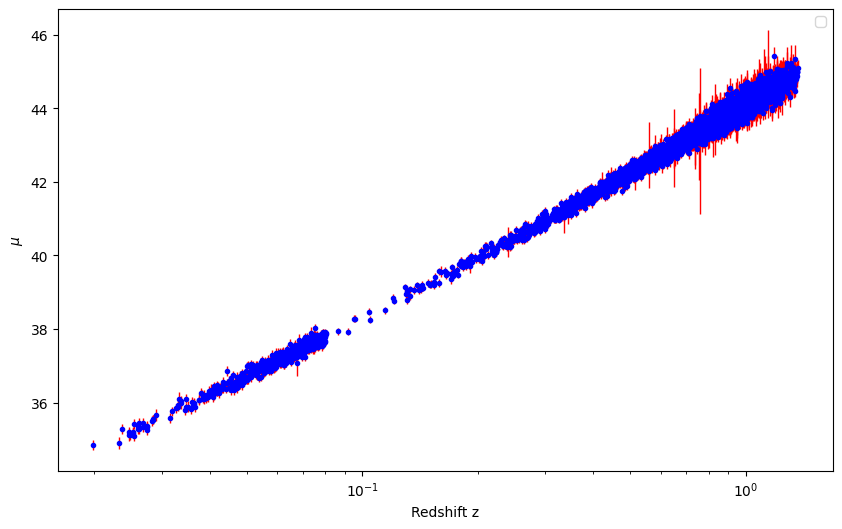

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [18]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [19]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [20]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [21]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((4630,), (4632,), (1157, 1), (1157, 1))

In [22]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 16
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0005)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,200,200,100])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 MCDropout_3 (MCDropout)     (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 4

In [23]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=1000, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/1000
290/290 [==============================] - 1s 2ms/step - loss: 250.1341 - val_loss: 41.0844
Epoch 2/1000
290/290 [==============================] - 0s 2ms/step - loss: 31.2785 - val_loss: 25.3782
Epoch 3/1000
290/290 [==============================] - 0s 2ms/step - loss: 24.8849 - val_loss: 22.6074
Epoch 4/1000
290/290 [==============================] - 0s 2ms/step - loss: 20.7570 - val_loss: 20.1992
Epoch 5/1000
290/290 [==============================] - 0s 2ms/step - loss: 18.3883 - val_loss: 18.5978
Epoch 6/1000
290/290 [==============================] - 0s 2ms/step - loss: 17.9799 - val_loss: 15.4118
Epoch 7/1000
290/290 [==============================] - 0s 2ms/step - loss: 16.4678 - val_loss: 14.9664
Epoch 8/1000
290/290 [==============================] - 0s 2ms/step - loss: 14.6245 - val_loss: 14.3982
Epoch 9/1000
290/290 [==============================] - 0s 2ms/step - loss: 14.1196 - val_loss: 15.1026
Epoch 10/1000
290/290 [==============================] - 0s 2ms

290/290 [==============================] - 0s 2ms/step - loss: 6.3007 - val_loss: 6.6238
Epoch 81/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.5870 - val_loss: 6.7060
Epoch 82/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.4105 - val_loss: 6.2809
Epoch 83/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.5528 - val_loss: 6.4877
Epoch 84/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.4488 - val_loss: 6.4327
Epoch 85/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.4099 - val_loss: 6.6696
Epoch 86/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.4431 - val_loss: 6.2748
Epoch 87/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.6102 - val_loss: 5.9267
Epoch 88/1000
290/290 [==============================] - 0s 2ms/step - loss: 6.5216 - val_loss: 6.4479
Epoch 89/1000
290/290 [==============================] - 1s 2ms/step - loss: 6.4648 - v

290/290 [==============================] - 0s 1ms/step - loss: 5.2171 - val_loss: 4.6784
Epoch 160/1000
290/290 [==============================] - 0s 2ms/step - loss: 5.1201 - val_loss: 5.5507
Epoch 161/1000
290/290 [==============================] - 0s 2ms/step - loss: 5.1535 - val_loss: 5.1585
Epoch 162/1000
290/290 [==============================] - 0s 2ms/step - loss: 5.2034 - val_loss: 5.2231
Epoch 163/1000
290/290 [==============================] - 0s 2ms/step - loss: 5.1571 - val_loss: 4.6365
Epoch 164/1000
290/290 [==============================] - 0s 2ms/step - loss: 5.0751 - val_loss: 5.2512
Epoch 165/1000
290/290 [==============================] - 0s 2ms/step - loss: 5.1631 - val_loss: 4.9955
Epoch 166/1000
290/290 [==============================] - 0s 2ms/step - loss: 4.8596 - val_loss: 5.2003
Epoch 167/1000
290/290 [==============================] - 0s 1ms/step - loss: 4.9779 - val_loss: 5.1580
Epoch 168/1000
290/290 [==============================] - 0s 2ms/step - loss: 5

Epoch 238/1000
290/290 [==============================] - 0s 2ms/step - loss: 4.1401 - val_loss: 3.9570
Epoch 239/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.9911 - val_loss: 3.8468
Epoch 240/1000
290/290 [==============================] - 0s 2ms/step - loss: 4.0376 - val_loss: 4.1558
Epoch 241/1000
290/290 [==============================] - 0s 2ms/step - loss: 4.0497 - val_loss: 3.8753
Epoch 242/1000
290/290 [==============================] - 0s 2ms/step - loss: 4.1648 - val_loss: 4.1665
Epoch 243/1000
290/290 [==============================] - 0s 2ms/step - loss: 4.1769 - val_loss: 3.8506
Epoch 244/1000
290/290 [==============================] - 1s 2ms/step - loss: 3.9652 - val_loss: 3.9261
Epoch 245/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.9853 - val_loss: 3.8787
Epoch 246/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.9014 - val_loss: 3.8945
Epoch 247/1000
290/290 [==============================] - 0s 2ms

Epoch 317/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.2733 - val_loss: 3.4291
Epoch 318/1000
290/290 [==============================] - 1s 2ms/step - loss: 3.1734 - val_loss: 3.3593
Epoch 319/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.1298 - val_loss: 3.1754
Epoch 320/1000
290/290 [==============================] - 1s 2ms/step - loss: 3.0196 - val_loss: 3.1322
Epoch 321/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.1436 - val_loss: 3.2453
Epoch 322/1000
290/290 [==============================] - 1s 2ms/step - loss: 3.1043 - val_loss: 2.9241
Epoch 323/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.2528 - val_loss: 3.1388
Epoch 324/1000
290/290 [==============================] - 1s 2ms/step - loss: 3.0512 - val_loss: 3.1286
Epoch 325/1000
290/290 [==============================] - 0s 2ms/step - loss: 3.1308 - val_loss: 3.3323
Epoch 326/1000
290/290 [==============================] - 0s 2ms

Epoch 396/1000
290/290 [==============================] - 0s 2ms/step - loss: 2.4543 - val_loss: 2.5112
Epoch 397/1000
290/290 [==============================] - 0s 2ms/step - loss: 2.4610 - val_loss: 2.3650
Epoch 398/1000
290/290 [==============================] - 1s 2ms/step - loss: 2.5001 - val_loss: 2.3933
Epoch 399/1000
290/290 [==============================] - 1s 2ms/step - loss: 2.4463 - val_loss: 2.4447
Epoch 400/1000
290/290 [==============================] - 0s 2ms/step - loss: 2.5013 - val_loss: 2.5250
Epoch 401/1000
290/290 [==============================] - 1s 2ms/step - loss: 2.3925 - val_loss: 2.4061
Epoch 402/1000
290/290 [==============================] - 0s 2ms/step - loss: 2.4557 - val_loss: 2.3161
Epoch 403/1000
290/290 [==============================] - 1s 2ms/step - loss: 2.4308 - val_loss: 2.3094
Epoch 404/1000
290/290 [==============================] - 1s 2ms/step - loss: 2.4317 - val_loss: 2.4330
Epoch 405/1000
290/290 [==============================] - 1s 2ms

Epoch 475/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.7830 - val_loss: 1.7964
Epoch 476/1000
290/290 [==============================] - 1s 2ms/step - loss: 1.8257 - val_loss: 1.8327
Epoch 477/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.7685 - val_loss: 1.7428
Epoch 478/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.8071 - val_loss: 1.8768
Epoch 479/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.8025 - val_loss: 1.8181
Epoch 480/1000
290/290 [==============================] - 1s 2ms/step - loss: 1.8112 - val_loss: 1.7496
Epoch 481/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.7870 - val_loss: 1.8559
Epoch 482/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.8060 - val_loss: 1.6752
Epoch 483/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.8651 - val_loss: 1.6708
Epoch 484/1000
290/290 [==============================] - 0s 2ms

Epoch 554/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.3223 - val_loss: 1.4158
Epoch 555/1000
290/290 [==============================] - 1s 2ms/step - loss: 1.2754 - val_loss: 1.3031
Epoch 556/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.2827 - val_loss: 1.3921
Epoch 557/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.2458 - val_loss: 1.3235
Epoch 558/1000
290/290 [==============================] - 1s 2ms/step - loss: 1.3035 - val_loss: 1.3708
Epoch 559/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.2738 - val_loss: 1.2864
Epoch 560/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.2812 - val_loss: 1.3074
Epoch 561/1000
290/290 [==============================] - 0s 2ms/step - loss: 1.2513 - val_loss: 1.2850
Epoch 562/1000
290/290 [==============================] - 1s 2ms/step - loss: 1.2931 - val_loss: 1.2410
Epoch 563/1000
290/290 [==============================] - 0s 2ms

Epoch 633/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.8968 - val_loss: 0.8958
Epoch 634/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.9290 - val_loss: 0.7869
Epoch 635/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.8698 - val_loss: 0.9125
Epoch 636/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.8740 - val_loss: 0.9035
Epoch 637/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.8795 - val_loss: 0.8962
Epoch 638/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.8857 - val_loss: 0.8516
Epoch 639/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.8890 - val_loss: 0.8823
Epoch 640/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.8889 - val_loss: 0.8971
Epoch 641/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.8465 - val_loss: 0.8206
Epoch 642/1000
290/290 [==============================] - 0s 2ms

Epoch 712/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.5539 - val_loss: 0.5194
Epoch 713/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.5364 - val_loss: 0.4975
Epoch 714/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.5273 - val_loss: 0.5389
Epoch 715/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.5390 - val_loss: 0.5706
Epoch 716/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.5359 - val_loss: 0.5264
Epoch 717/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.5383 - val_loss: 0.5399
Epoch 718/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.5287 - val_loss: 0.5153
Epoch 719/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.5157 - val_loss: 0.5331
Epoch 720/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.5066 - val_loss: 0.4898
Epoch 721/1000
290/290 [==============================] - 0s 2ms

Epoch 791/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.3017 - val_loss: 0.3183
Epoch 792/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.2922 - val_loss: 0.2794
Epoch 793/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.2939 - val_loss: 0.2925
Epoch 794/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.2962 - val_loss: 0.2939
Epoch 795/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.2916 - val_loss: 0.2873
Epoch 796/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.2885 - val_loss: 0.2930
Epoch 797/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.2933 - val_loss: 0.3198
Epoch 798/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.2862 - val_loss: 0.3010
Epoch 799/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.2776 - val_loss: 0.2811
Epoch 800/1000
290/290 [==============================] - 0s 2ms

Epoch 870/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1600 - val_loss: 0.1660
Epoch 871/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.1583 - val_loss: 0.1671
Epoch 872/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1577 - val_loss: 0.1563
Epoch 873/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1588 - val_loss: 0.1705
Epoch 874/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1583 - val_loss: 0.1623
Epoch 875/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.1626 - val_loss: 0.1665
Epoch 876/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.1594 - val_loss: 0.1547
Epoch 877/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1588 - val_loss: 0.1650
Epoch 878/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1511 - val_loss: 0.1542
Epoch 879/1000
290/290 [==============================] - 0s 2ms

Epoch 949/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1008 - val_loss: 0.1200
Epoch 950/1000
290/290 [==============================] - 1s 2ms/step - loss: 0.1004 - val_loss: 0.1010
Epoch 951/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1043 - val_loss: 0.1106
Epoch 952/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1045 - val_loss: 0.0949
Epoch 953/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1027 - val_loss: 0.1024
Epoch 954/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1008 - val_loss: 0.1032
Epoch 955/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1051 - val_loss: 0.1119
Epoch 956/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1021 - val_loss: 0.0962
Epoch 957/1000
290/290 [==============================] - 0s 2ms/step - loss: 0.1039 - val_loss: 0.1038
Epoch 958/1000
290/290 [==============================] - 0s 2ms

In [24]:
model_train.history['val_loss'][-1]

0.09126176685094833

(0.0, 200.0)

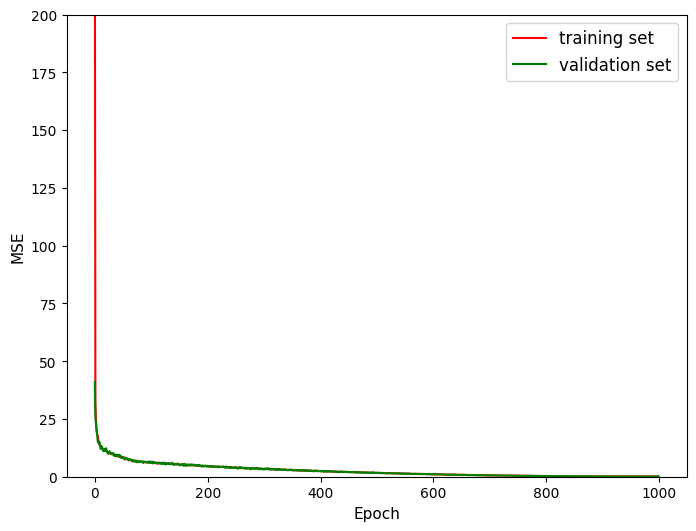

In [25]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 200)

In [26]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(zmin, zmax, test_batch_size)

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 927us/step


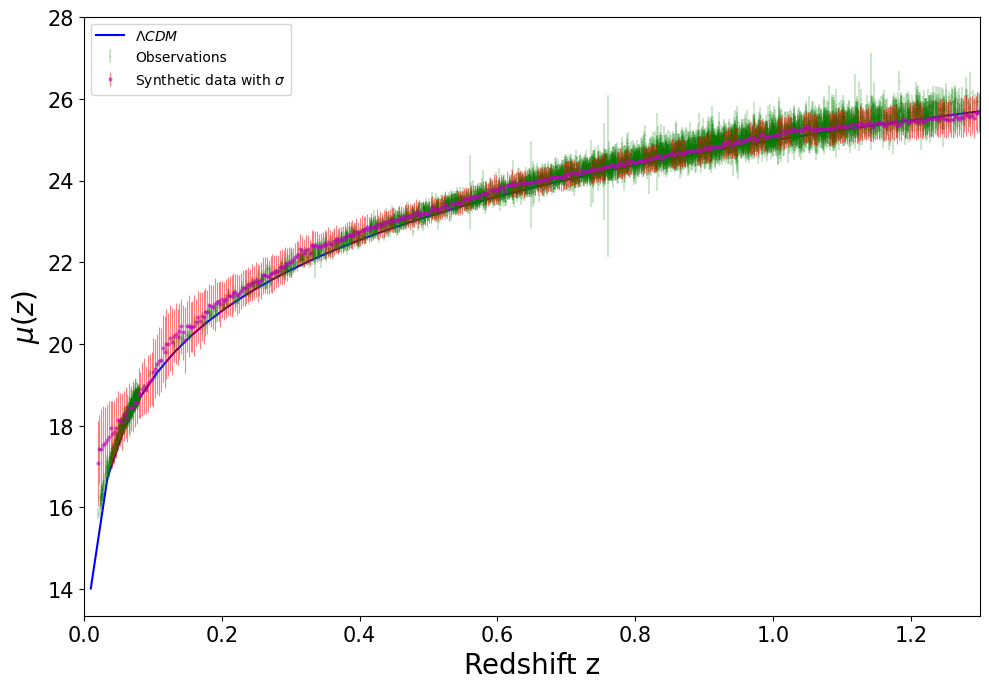

In [28]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors